<h1 style="color: #001a79;">Exercise</h1>

<hr style="border-top: 1px solid #001a79;" />

<i style="color: #001a79;">Remember to do these exercises in your own notebook in your assessment repository.</i>

Use numpy's polyfit to fit polynomials to the 2 datasets in the next jupyter cell.

In [1]:
# for numerical operations
import numpy as np

# dataset 1
x1 = np.array([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0])
y1 = np.array([1.3, 1.2, 9.4, 27.3, 63.1, 126.5, 217.3, 341.5, 512.8, 729.3, 1001.8, 1332.7, 1728.9, 2198.8, 2743.7, 3376.7])

# dataset 2
x2 = np.array([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0])
y2 = np.array([5.7, 16.6, 58.0, 278.9, 1069.3, 3181.4, 7844.3, 16883.9, 32854.9, 59144.2, 100106.7, 161166.3, 248958.6])

In [2]:
# for creating dataframes
import pandas as pd

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# for generating polynomial feature
from sklearn.preprocessing import PolynomialFeatures

# for model creation: access to ordinary least squared function
import statsmodels.api as sm

# for calculating mean squared error
from sklearn.metrics import mean_squared_error

# format plots
sns.set_style("darkgrid")

<h2 style="color: #001a79;">Plotting the datasets</h2>

<hr style="border-top: 1px solid #001a79;" />

First lets make a function that returns the predicted y-values for the passed x and y-actual values for n degrees of freedom. This function will leverage the *polyfit* method of numpy to get an array of polynomial coefficients from the highest to lowest power. These coefficients will then be passed to numpys *polyval* method along with the predictor values to return the predicted y_values for each dataset.

In [3]:
# https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html
# https://numpy.org/doc/stable/reference/generated/numpy.polyval.html

def get_y_pred(x, y, df):
    '''returns polynomial y-predicted vals for passed x, y and degrees of freedrom'''
    # get polynomial coeffecients from high to lowest order
    params = np.polyfit(x, y, df)
    
    # return predicted y-values using coefficients and x as predictor vals
    return np.polyval(params, x)

In [4]:
# sanity check...return y_pred_vals
get_y_pred(x1, y1, 2)

array([ 137.31262255,   29.01183824,  -34.26860294,  -52.52870098,
        -25.76845588,   46.01213235,  162.81306373,  324.63433824,
        531.47595588,  783.33791667, 1080.22022059, 1422.12286765,
       1809.04585784, 2240.98919118, 2717.95286765, 3239.93688725])

In [5]:
def plot_grid(plot_idx, plot_data, plot_label):
    '''This function plots a 2x2 matrix on a pre-existing figure object'''
    
    # pull out x, y and degrees of freedom vals
    x, y, df = plot_data[0], plot_data[1], plot_data[2]

    # get predicted y polynomial vals from passed degrees of freedom
    y_pred = get_y_pred(x, y, df = df)
    
    # Plot x and y  &  x and y_pred
    axs[plot_idx].plot(x, y, 'r.')  
    axs[plot_idx].plot(x, y_pred, 'k--')  
    
    # add title to plots
    axs[plot_idx].set_title(plot_label)

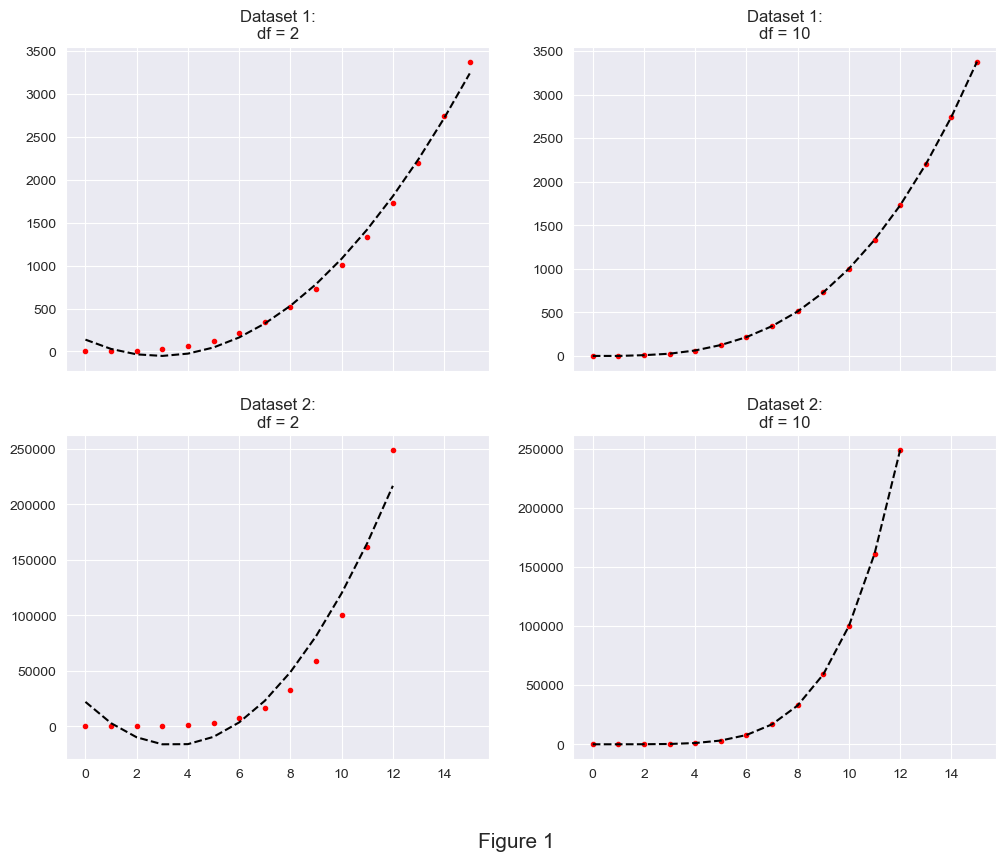

In [6]:
# lets structure the data for passing to plot grid function...

# each list element is a tuple containing x, y and degrees of freedom
plot_list = [(x1, y1, 2), (x1, y1, 10), (x2, y2, 2), (x2, y2, 10)]

# contains the title for each subplot
plot_labels = ['Dataset 1:\ndf = 2', 'Dataset 1:\ndf = 10',
               'Dataset 2:\ndf = 2', 'Dataset 2:\ndf = 10']

# generate figure with 2 rows & 2 cols
fig, axs = plt.subplots(2, 2, sharex=True, figsize = (12, 8))
plt.subplots_adjust(wspace = 0.2, hspace = 0.2, top = 1)
plt.figtext(0.5, 0, 'Figure 1', wrap = True, horizontalalignment = 
            'center', fontsize = 15);

# generate 2d (2 x 2) array  
arr = np.arange(8).reshape(2, 2, 2)

# iterate over 2d array to get tuple of indices and index val
for index, indices in enumerate(np.ndindex(arr.shape[:2])):
    plot_grid(indices, plot_list[index], plot_labels[index])   

First lets look at the top two plots (dataset 1). We can clearly see that the 10th order polynomial model fits the line better to the data than the 2nd order model, thats not to say that it's a better model as we must be careful not to overfit the data. Overfitting is when the model is reliant on the training data. Rajbangshi (2022) describes this well by detailing how an overfitted model memorizes the training data instead of learning and understanding the underlying trend of the data [1]. The bottom two plots (dataset 2) unsurprisingly also shows a better fit for 10 degrees of freedom. Lets explore how we bridge the gap between getting a good curve fit and overfitting the model.

<h2 style="color: #001a79;">Bridging the Gap</h2>

<hr style="border-top: 1px solid #001a79;" />

Take datasets 1 modelled above with 13 datapoints, we can exactly fit the data if our polynomial model is to the 12th degree. Obviously this approach would not result in a simple model so we need a way evaluate when the polynomial degree is getting too high. When dealing with straight lines (polynomial degree 1) a good cost function is the mean squared error, however this metric does not punish the model for increasing the degrees of freedom, lets look for one that does.

<br>

One such metric described by is the Bayesian Information Criterion (BIC). He describes how the formula (shown below) calculates the maximum likelyhood function $2ln(\hat{L})$ which esentially captures how likely our data is explained by the given model. The BIC formula then takes the number of model parameters into consideration by adding a penalty term into the formula. This term $kln(n)$ helps to balance the maximum likelihood function [2]. Lets leverage sklearn library to calculate BIC as a cost function and compare it to mean squared error.


$BIC = kln(n) - 2ln(\hat{L})$

In [7]:
# sk learn to help us calculate bic
# method adapted from: https://swapnilin.medium.com/bayesian-information-criterion-bic-aa0400f9c533
def calc_bic(x, y, max_df):
    '''returns bic list, order list and mse list from 
    passed x and y vals to passed degrees of freedom'''
    
    bic = []        # Bayesian information criterion
    order = []      # model order list
    mses = []       # mean squared error list
    
    # put all x and y vals into dict for both datasets
    plot_vars = {'x': x, 'y': y}
    
    # convert dict to dataframe for sklearn operations
    dframe = pd.DataFrame.from_dict(plot_vars)
    
    # seperate out x and y
    x, y = dframe[['x']], dframe[['y']] 
    
    for df in range(max_df):

        # calculate root mean squared error and append to list  
        mse = mean_squared_error(y, get_y_pred(plot_vars.get('x'), y, df))
        
        # append mse to mses list
        mses.append(mse)

        # Generate polynomial feature matrix 
        pf = PolynomialFeatures(degree = df)
        xn = pf.fit_transform(x)
        
        # fit x and y to the model via ordinary least squares method
        model = sm.OLS(y, xn).fit()
        
        # append model bic values to list
        bic.append(model.bic)
        
        # append model order
        order.append(df)
        
    return bic, order, mses

In [8]:
bic_d1, orderd1, mse1 = calc_bic(x1, y1, max_df = 10)
bic_d2, orderd2, mse2, = calc_bic(x2, y2, max_df = 10)

# have a look at bic
mse1

[1095678.5508984374,
 186530.13659283082,
 5635.443407322294,
 0.8259236946296906,
 0.8255766719010764,
 0.8013173957590511,
 0.6828649883156775,
 0.6451450662424945,
 0.641611345011607,
 0.6276115485524649]

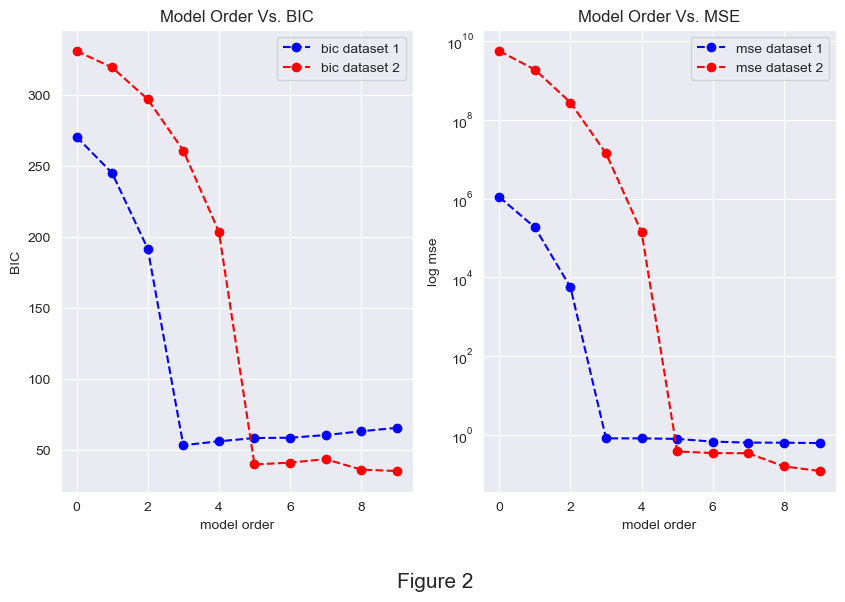

In [9]:
# plot bic vs mse
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 6))
plt.figtext(0.5, -0.05, 'Figure 2', wrap = True, horizontalalignment = 'center', fontsize = 15);

# plot order vs bics for different datasets
ax1.plot(orderd1, bic_d1, '--bo', label = 'bic dataset 1')
ax1.plot(orderd2, bic_d2, '--ro', label = 'bic dataset 2')

ax2.plot(orderd1, mse1, '--bo', label = 'mse dataset 1')
ax2.plot(orderd2, mse2, '--ro', label = 'mse dataset 2')

# set axis to log scale for better visual
ax2.set_yscale('log')

# format plot
ax1.set_title("Model Order Vs. BIC")
ax2.set_title("Model Order Vs. MSE")
ax1.set_ylabel('BIC')
ax2.set_ylabel('log mse')
ax1.set_xlabel('model order')
ax2.set_xlabel('model order')
ax1.legend()
ax2.legend()
plt.show();

Looking at datset1 BIC values above we can see how they rapidly drop to the 3rd model order and then start slowly increasing. Interestingly the natural log of the mean squared error (mse) shows a similar drop to the 3rd model order but then the decrease continues but a lower rate. The increase of BIC (at order > 3) is due to the penalty term which punishes the model for having more parameters associated with it whearas the continual reducion of mse is expected as the residuals lessen and the model becomes overfitted. Figure 2 if taken at face value indicates that 3rd order polynomial would best suit datset 1 (lowest BIC & mse). Dataset2  has its lowest BIC & mse at model order of 5.

<h2 style="color: #001a79;">References</h2>

<hr style="border-top: 1px solid #001a79;" />

1. Rajbangshi, A, 2020, Overfitting and Underfitting in Machine Learning, medium.com, Available at [Ref Link](https://medium.com/analytics-vidhya/overfitting-and-underfitting-in-machine-learning-d829d8501335)<br>
(Accessed 10 November 2022). 

<br>

2. Klassen, M, 2020, An Intuitive Explanation of the Bayesian Information Criterion, towards data science, Available at [Ref Link](https://towardsdatascience.com/an-intuitive-explanation-of-the-bayesian-information-criterion-71a7a3d3a5c5)<br>
(Accessed 11 November 2022).

<hr style="border-top: 1px solid rgb(0, 91, 94);" />

<h2 style="color: rgb(0, 91, 94);">End</h2>